In [67]:
import os
import json
import requests
from datetime import datetime
from shapely.geometry import box
from pathlib import Path
import os
import requests
import zipfile
import shutil
import numpy as np
import rasterio
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from scipy.ndimage import uniform_filter, variance
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import NMF
from sklearn.preprocessing import RobustScaler    


# Declare Variables and Get the Data

In [2]:
# ─────────────────────────────────────────
# DIRECTORIES
# ─────────────────────────────────────────
BASE_DIR       = Path("sentinel1_pipeline")
DOWNLOAD_DIR   = BASE_DIR / "downloads"    # temporary: SAFE files deleted after processing
PROCESSED_DIR  = BASE_DIR / "processed"   # permanent: compressed GeoTIFFs
STACK_DIR      = BASE_DIR / "stacks"      # per-AOI stacks

for d in [DOWNLOAD_DIR, PROCESSED_DIR, STACK_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ─────────────────────────────────────────
# TIME RANGE (per recommendations: 18 months)
# ─────────────────────────────────────────
START_DATE = "2015-01-01T00:00:00.000Z"
END_DATE   = "2020-01-01T00:00:00.000Z"

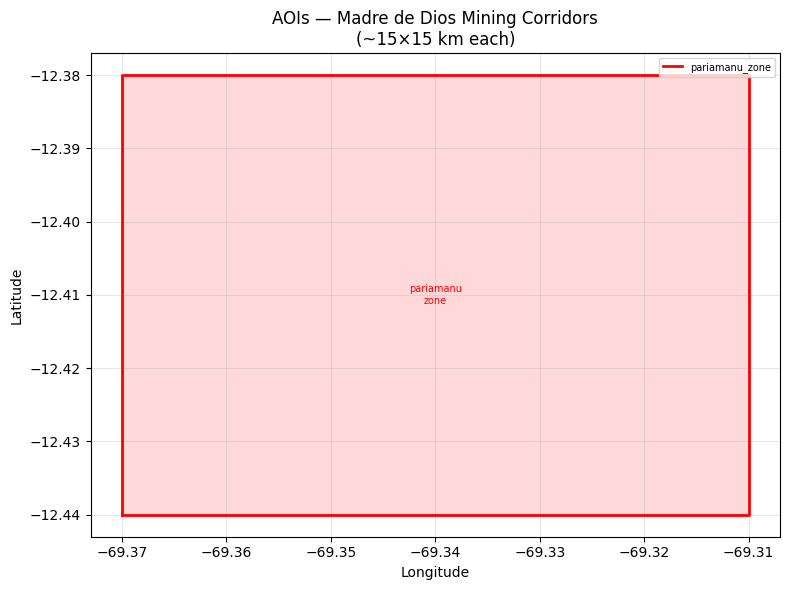

✅ AOIs defined and plotted.


In [ ]:
AOIS = {
    # "madre_de_dios_main": {
    #     "bbox": (-70.10, -12.60, -69.97, -12.48),
    #     "description": "Main Madre de Dios river mining corridor"
    # },
    # "inambari_corridor": {
    #     "bbox": (-70.15, -13.25, -70.02, -13.12),
    #     "description": "Inambari river alluvial mining zone"
    # },
    "pariamanu_zone": {"bbox": (-69.37, -12.44, -69.31, -12.38), "description": "Pariamanu zone"},
    # "delta_uno_hotspot": {
    #     "bbox": (-69.85, -12.72, -69.72, -12.59),
    #     "description": "MAAP-documented active mining hotspot"
    # },
    # "huepetuhe_mining": {
    #     "bbox": (-70.55, -13.10, -70.42, -12.97),
    #     "description": "Huepetuhe mining district (historical baseline)"
    # },
}

# Quick visual overview
fig, ax = plt.subplots(figsize=(8, 6))
colors = ["red", "blue", "green", "orange"]

for (name, aoi), color in zip(AOIS.items(), colors):
    b = aoi["bbox"]
    # Draw rectangle
    rect_x = [b[0], b[2], b[2], b[0], b[0]]
    rect_y = [b[1], b[1], b[3], b[3], b[1]]
    ax.plot(rect_x, rect_y, color=color, linewidth=2, label=name)
    ax.fill(rect_x, rect_y, alpha=0.15, color=color)
    ax.text((b[0]+b[2])/2, (b[1]+b[3])/2, name.replace("_", "\n"),
            ha="center", va="center", fontsize=7, color=color)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("AOIs — Madre de Dios Mining Corridors\n(~15×15 km each)")
ax.legend(loc="upper right", fontsize=7)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(BASE_DIR / "aois_map.png", dpi=150)
plt.show()
print("✅ AOIs defined and plotted.")

📚 Building raster stacks...

  ✅ pariamanu_zone: stack shape (174, 3, 512, 512) | saved → pariamanu_zone_stack.nc


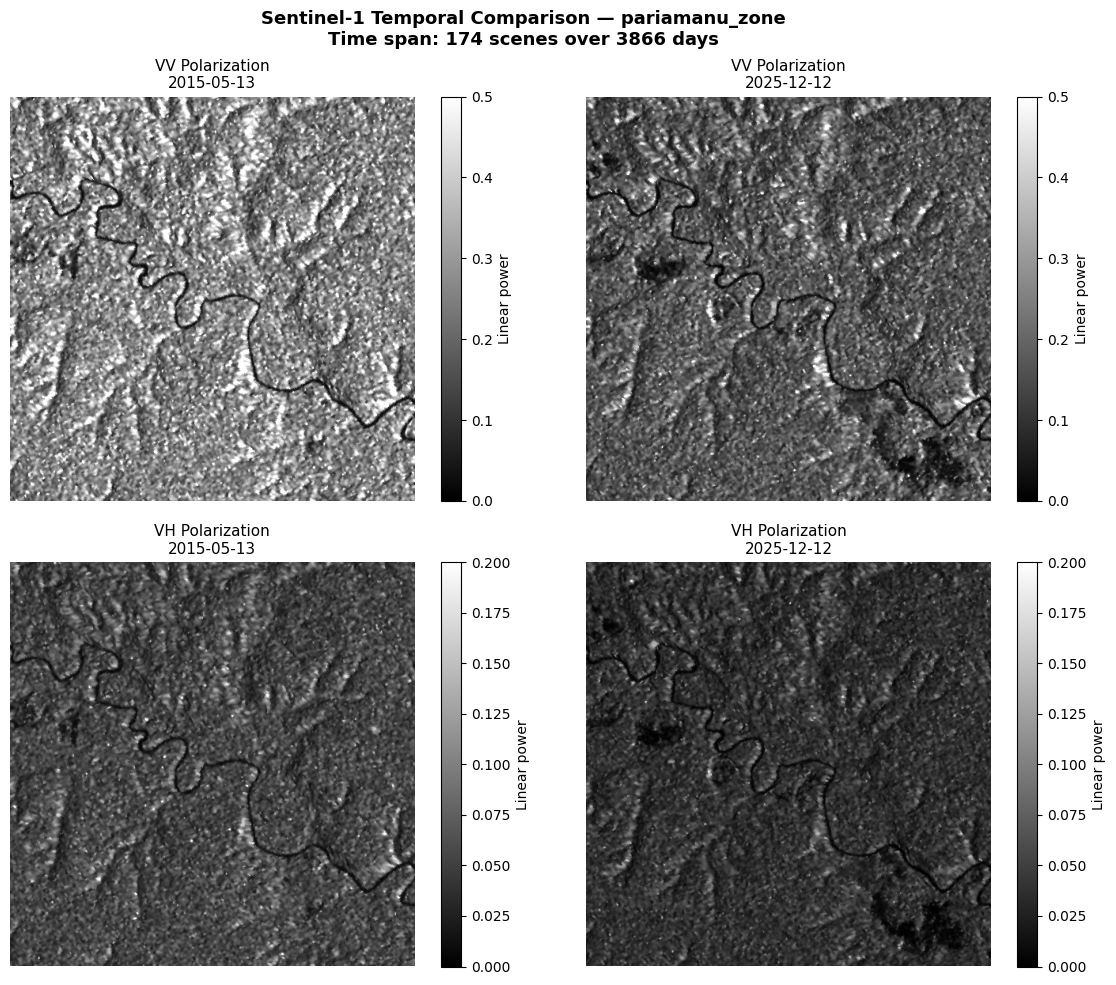


📊 Temporal comparison saved: sentinel1_pipeline/pariamanu_zone_temporal_comparison.png


In [69]:
# Cell 7: Build per-AOI temporal stacks

def build_stack(aoi_name):
    """
    Load all processed GeoTIFFs for an AOI as an xarray DataArray
    with a 'time' dimension. Now handles 3 bands: VV, VH, ratio.
    """
    tif_files = sorted((PROCESSED_DIR / aoi_name).glob("*.tif"))
    if not tif_files:
        print(f"  ⚠️ No files found for {aoi_name}")
        return None

    arrays, dates = [], []
    for f in tif_files:
        date_str = f.name[:10]   # "2022-03-15"
        try:
            date = np.datetime64(date_str)
        except:
            continue

        with rasterio.open(f) as src:
            arr = src.read()    # shape: (3, H, W) - all 3 bands
            transform = src.transform
            n_bands, height, width = arr.shape

        arrays.append(arr)
        dates.append(date)

    if not arrays:
        return None

    stack = np.stack(arrays, axis=0)    # (T, 3, H, W)

    # Build xarray with band dimension
    da_stack = xr.DataArray(
        data   = stack,
        dims   = ["time", "band", "y", "x"],
        coords = {
            "time": dates,
            "band": ["VV", "VH", "VV_VH_ratio"]
        },
        attrs  = {
            "aoi":         aoi_name,
            "description": "Sentinel-1 VV, VH, and VV/VH ratio (linear power), 30m, Lee-filtered",
            "units":       "linear power"
        }
    )

    # Save stack for later
    stack_path = STACK_DIR / f"{aoi_name}_stack.nc"
    da_stack.to_netcdf(stack_path)
    print(f"  ✅ {aoi_name}: stack shape {stack.shape} | saved → {stack_path.name}")

    return da_stack


# ─── Build all stacks ───
print("📚 Building raster stacks...\n")
STACKS = {}
for aoi_name in AOIS.keys():
    STACKS[aoi_name] = build_stack(aoi_name)


# ─── Temporal comparison: First vs Last date ───
first_aoi = next(iter(STACKS))
ds = STACKS[first_aoi]

if ds is not None:
    # print(f"\nExample stack: {first_aoi}")
    # print(ds)
    
    # Get first and last dates
    first_date = ds.time[0]
    last_date  = ds.time[-1]
    
    # Extract data
    vv_first = ds.sel(band="VV", time=first_date).values
    vv_last  = ds.sel(band="VV", time=last_date).values
    vh_first = ds.sel(band="VH", time=first_date).values
    vh_last  = ds.sel(band="VH", time=last_date).values
    
    # Date strings
    date_first_str = str(first_date.values)[:10]
    date_last_str  = str(last_date.values)[:10]
    
    # ══════════════════════════════════════════════════════
    # Plot: 2×2 grid (VV and VH, first and last)
    # ══════════════════════════════════════════════════════
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # VV - First date
    im1 = axes[0, 0].imshow(vv_first, cmap="gray", vmin=0, vmax=0.5)
    axes[0, 0].set_title(f"VV Polarization\n{date_first_str}", fontsize=11)
    axes[0, 0].axis("off")
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, label="Linear power")
    
    # VV - Last date
    im2 = axes[0, 1].imshow(vv_last, cmap="gray", vmin=0, vmax=0.5)
    axes[0, 1].set_title(f"VV Polarization\n{date_last_str}", fontsize=11)
    axes[0, 1].axis("off")
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, label="Linear power")
    
    # VH - First date
    im3 = axes[1, 0].imshow(vh_first, cmap="gray", vmin=0, vmax=0.2)
    axes[1, 0].set_title(f"VH Polarization\n{date_first_str}", fontsize=11)
    axes[1, 0].axis("off")
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, label="Linear power")
    
    # VH - Last date
    im4 = axes[1, 1].imshow(vh_last, cmap="gray", vmin=0, vmax=0.2)
    axes[1, 1].set_title(f"VH Polarization\n{date_last_str}", fontsize=11)
    axes[1, 1].axis("off")
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, label="Linear power")
    
    plt.suptitle(
        f"Sentinel-1 Temporal Comparison — {first_aoi}\n"
        f"Time span: {len(ds.time)} scenes over {(last_date - first_date).values.astype('timedelta64[D]').astype(int)} days",
        fontsize=13, fontweight="bold"
    )
    plt.tight_layout()
    plt.savefig(BASE_DIR / f"{first_aoi}_temporal_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    print(f"\n📊 Temporal comparison saved: {BASE_DIR}/{first_aoi}_temporal_comparison.png")

In [ ]:
# I am just randomly selecting 5 days per month, undo this when training !
# STACKS = {
#     name: stack.groupby('time.month').map(
#         lambda x: x.isel(time=np.random.choice(len(x.time), min(10, len(x.time)), replace=False)) if len(x.time) > 0 else x
#     ) if stack is not None else None
#     for name, stack in STACKS.items()
# }

In [70]:
# Check shape of all stacks
for name, stack in STACKS.items():
    if stack is not None:
        print(f"{name}: {stack.shape}")
    else:
        print(f"{name}: None")

pariamanu_zone: (174, 3, 512, 512)


# Train NMF

In [71]:
# ═══════════════════════════════════════════════════════
# Configuration
# ═══════════════════════════════════════════════════════

N_COMPONENTS = 4
BAND_STRATEGY = "all"  # "vv", "vh", "ratio", "all"
COMPONENT_LABELS = ["Forest", "Water/Flood", "Clearing", "Mining"]
COMPONENT_CMAPS = ["YlGn", "Blues", "YlOrBr", "Reds"]

In [ ]:
def preprocess_band_data(stack_da, band_strategy="all", 
                         outlier_percentile=1.0, min_valid_frac=0.7):
    """
    Extract and preprocess - EXACTLY like Document 2
    """
    
    if band_strategy == "vv":
        data = stack_da.sel(band="VV").values
        band_names = ["VV"]
    elif band_strategy == "vh":
        data = stack_da.sel(band="VH").values
        band_names = ["VH"]
    elif band_strategy == "ratio":
        data = stack_da.sel(band="VV_VH_ratio").values
        band_names = ["VV/VH"]
    elif band_strategy == "all":
        data = stack_da.values
        band_names = ["VV", "VH", "VV/VH"]
    else:
        raise ValueError(f"Unknown band_strategy: {band_strategy}")

    # Handle multi-band: reshape to (T*n_bands, H, W)
    if data.ndim == 4:
        T, n_bands, H, W = data.shape
        data = data.transpose(1, 0, 2, 3).reshape(n_bands * T, H, W)
        print(f"   Multi-band: {n_bands} bands × {T} times = {n_bands*T} features")
    else:
        T, H, W = data.shape
        n_bands = 1
    
    # Replace invalid values
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Clip outliers PER FEATURE (band-time combination)
    if outlier_percentile > 0:
        for i in range(data.shape[0]):
            frame = data[i]
            valid = frame[frame > 0]
            if len(valid) > 100:
                lower = np.percentile(valid, outlier_percentile)
                upper = np.percentile(valid, 100 - outlier_percentile)
                data[i] = np.clip(frame, lower, upper)
    
    # Valid pixels mask
    valid_mask = np.mean(data > 0, axis=0) >= min_valid_frac
    
    n_features = data.shape[0]
    
    return data, band_names, valid_mask, n_bands, T, (H, W)

In [ ]:
def run_nmf_pipeline(stack_da, aoi_name, band_strategy = "all"):
    """
    NMF pipeline matching Document 2 preprocessing
    """
    
    print(f"\n{'='*60}")
    print(f"NMF Pipeline: {aoi_name}")
    print(f"{'='*60}")
    
    # Sort first
    stack_da = stack_da.sortby('time')
    
    # Preprocess
    print("\n[1/5] Preprocessing...")
    data, band_names, valid_mask_2d, n_bands, n_timesteps, spatial_shape = preprocess_band_data(
        stack_da,
        band_strategy=BAND_STRATEGY,
        outlier_percentile=1.0,  # Document 2 value
        min_valid_frac=0.7
    )
    
    n_features, H, W = data.shape
    print(f"   Shape: {n_features} features × {H}×{W} pixels")
    print(f"   Bands: {', '.join(band_names)}")
    
    # Flatten to matrix: (n_pixels, n_features) - Document 2 convention
    print("\n[2/5] Building matrix...")
    V = data.reshape(n_features, -1).T  # (n_pixels, n_features)
    valid_mask_1d = valid_mask_2d.flatten()
    
    print(f"   V matrix: {V.shape}")
    print(f"   Valid pixels: {valid_mask_1d.sum():,}")
    
    # Normalize - RobustScaler
    print("\n[3/5] Normalizing...")
    from sklearn.preprocessing import RobustScaler
    
    scaler = RobustScaler()
    V_scaled = scaler.fit_transform(V)
    V_norm = V_scaled - V_scaled.min()
    
    print(f"   Normalized range: [{V_norm.min():.2e}, {V_norm.max():.2e}]")
    
    # Fit NMF
    print("\n[4/5] Fitting NMF...")
    model = NMF(
        n_components=N_COMPONENTS,
        init='nndsvda',
        solver='mu',
        beta_loss='kullback-leibler',
        max_iter=500,
        random_state=42,
        alpha_W=0.0,
        alpha_H=0.1,
        l1_ratio=0.5
    )
    
    W_pixels = model.fit_transform(V_norm)  # (n_pixels, k)
    H_features = model.components_           # (k, n_features)
    
    print(f"   Reconstruction error: {model.reconstruction_err_:.4f}")
    
    # Extract temporal activation per band
    print("\n[5/5] Extracting temporal patterns...")
    # H_features is (k, n_features) where n_features = n_bands * n_timesteps
    H_reshaped = H_features.reshape(N_COMPONENTS, n_bands, n_timesteps)
    # Shape: (k, n_bands, n_timesteps)
    
    # Transpose to (n_bands, n_timesteps, k) for visualization
    temporal_activation = H_reshaped.transpose(1, 2, 0)
    
    # Create spatial maps from W_pixels
    spatial_maps = np.zeros((H, W, N_COMPONENTS))
    spatial_maps_flat = spatial_maps.reshape(-1, N_COMPONENTS)
    spatial_maps_flat[valid_mask_1d] = W_pixels[valid_mask_1d]
    spatial_maps = spatial_maps_flat.reshape(H, W, N_COMPONENTS)
    
    # Package results
    results = {
        "W_maps": spatial_maps,
        "temporal_activation": temporal_activation,
        "H_matrix": H_features,
        "dates": stack_da.time.values,
        "band_info": {
            "band_names": band_names,
            "n_bands": n_bands,
            "n_timesteps": n_timesteps,
            "shape": (H, W)
        },
        "valid_mask": valid_mask_2d,
        "aoi_name": aoi_name
    }
    
    # Save
    save_dir = STACK_DIR / aoi_name
    save_dir.mkdir(exist_ok=True, parents=True)
    
    np.save(save_dir / "W_maps.npy", spatial_maps)
    np.save(save_dir / "temporal_activation.npy", temporal_activation)
    np.save(save_dir / "valid_mask.npy", valid_mask_2d)
    
    print(f"\n✅ Saved to {save_dir}/")
    
    return results

In [ ]:
# ═══════════════════════════════════════════════════════
# Run on all AOIs
# ═══════════════════════════════════════════════════════

NMF_RESULTS = {}

for aoi_name, stack in STACKS.items():
    if stack is None or len(stack.time) < 10:
        print(f"⚠️ Skipping {aoi_name}")
        continue
    
    try:
        results = run_nmf_pipeline(stack, aoi_name, band_strategy = BAND_STRATEGY)
        NMF_RESULTS[aoi_name] = results
        # visualize_results(results)
        
    except Exception as e:
        print(f"❌ Failed for {aoi_name}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n✅ Complete: {len(NMF_RESULTS)} AOIs processed")


NMF Pipeline: pariamanu_zone

[1/5] Preprocessing...
   Multi-band: 3 bands × 174 times = 522 features
   Shape: 522 features × 512×512 pixels
   Bands: VV, VH, VV/VH

[2/5] Building matrix...
   V matrix: (262144, 522)
   Valid pixels: 262,144

[3/5] Normalizing...
   Normalized range: [0.00e+00, 4.97e+00]

[4/5] Fitting NMF...


# Visualizations

This visualization displays the two key outputs of NMF decomposition - temporal and spatial patterns - after combining information from all bands.

During NMF fitting, the data matrix X has shape:
(3 × n_timesteps, n_pixels) = (180, 262,144) in your case
This means: 60 timesteps × 3 bands = 180 feature rows
Each row represents one band at one time point

The temporal_activation extraction (extract_temporal_activation function):
This averages VV, VH, and ratio contributions to get a single temporal signature per component.

he spatial maps (W_maps) are derived from H matrix:
H contains spatial weights that also integrate all 3 bands
The NMF learns which spatial locations show consistent patterns across all bands

In [75]:
# ═══════════════════════════════════════════════════════
# Visualization
# ═══════════════════════════════════════════════════════

def visualize_results(results):
    """
    Create figures showing temporal activation per band.
    """
    
    aoi_name = results["aoi_name"]
    temporal_activation = results["temporal_activation"]
    W_maps = results["W_maps"]
    dates = results["dates"]
    band_names = results["band_info"]["band_names"]
    
    n_bands, T, k = temporal_activation.shape
    
    # Sort dates and get sorting indices
    sorted_indices = np.argsort(dates)
    dates_sorted = dates[sorted_indices]
    
    # ─────────────────────────────────────────────────────
    # FIGURE 1: Temporal Activation PER BAND
    # ─────────────────────────────────────────────────────
    fig, axes = plt.subplots(k, n_bands, figsize=(6*n_bands, 2.5*k), sharex=True)
    
    for comp in range(k):
        for band in range(n_bands):
            if n_bands > 1:
                ax = axes[comp, band]
            else:
                ax = axes[comp]
            
            # Plot with sorted time indices
            temporal_sorted = temporal_activation[band, sorted_indices, comp]
            
            ax.plot(temporal_sorted, linewidth=2, color=plt.cm.tab10(comp))
            ax.fill_between(range(T), temporal_sorted, 
                           alpha=0.3, color=plt.cm.tab10(comp))
            ax.set_ylabel("Activation", fontsize=9)
            ax.set_title(f"Component {comp+1} ({COMPONENT_LABELS[comp]})\n"
                        f"{band_names[band]} band", fontsize=10)
            ax.grid(True, alpha=0.3)
            
            # Mark peak
            peak_idx = np.argmax(temporal_sorted)
            ax.axvline(peak_idx, color="red", linestyle="--", 
                      linewidth=0.8, alpha=0.7)
    
    # Date labels on bottom row - now sorted
    date_labels = [str(d)[:7] for d in dates_sorted]
    step = max(1, T // 8)
    for band in range(n_bands):
        if n_bands > 1:
            axes[-1, band].set_xticks(range(0, T, step))
            axes[-1, band].set_xticklabels(date_labels[::step], 
                                           rotation=30, ha="right")
        else:
            axes[-1].set_xticks(range(0, T, step))
            axes[-1].set_xticklabels(date_labels[::step], 
                                    rotation=30, ha="right")
    
    plt.suptitle(f"Component Temporal Activation (per band)\n{aoi_name}", 
                fontsize=12)
    plt.tight_layout()
    plt.savefig(BASE_DIR / f"{aoi_name}_temporal_per_band.png", dpi=150)
    plt.show()
            
    # ─────────────────────────────────────────────────────
    # FIGURE 2: Spatial Weight Maps
    # ─────────────────────────────────────────────────────
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i in range(k):
        ax = axes[i]
        wmap = W_maps[:, :, i]
        im = ax.imshow(wmap, cmap=COMPONENT_CMAPS[i], interpolation="nearest")
        plt.colorbar(im, ax=ax, fraction=0.046, label="Weight")
        ax.set_title(f"Component {i+1}: {COMPONENT_LABELS[i]}", fontsize=10)
        ax.axis("off")
    
    plt.suptitle(f"Component Spatial Maps\n{aoi_name}", fontsize=12)
    plt.tight_layout()
    plt.savefig(BASE_DIR / f"{aoi_name}_spatial_maps.png", dpi=150)
    plt.show()

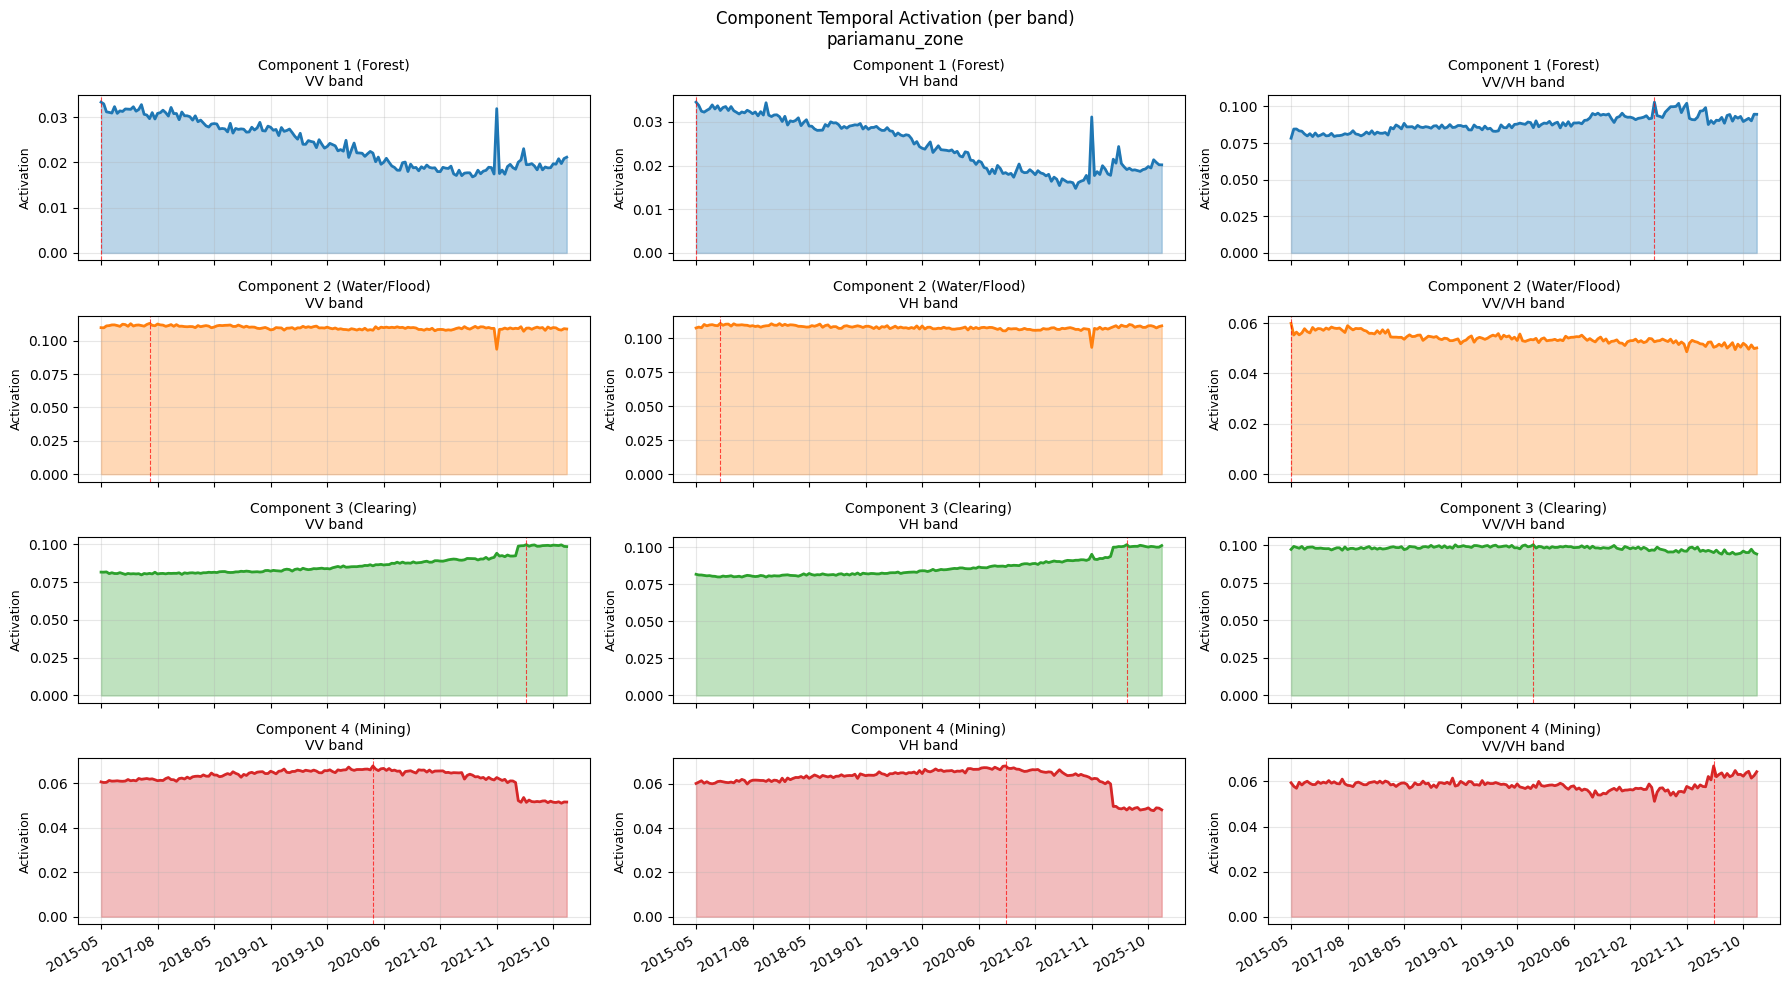

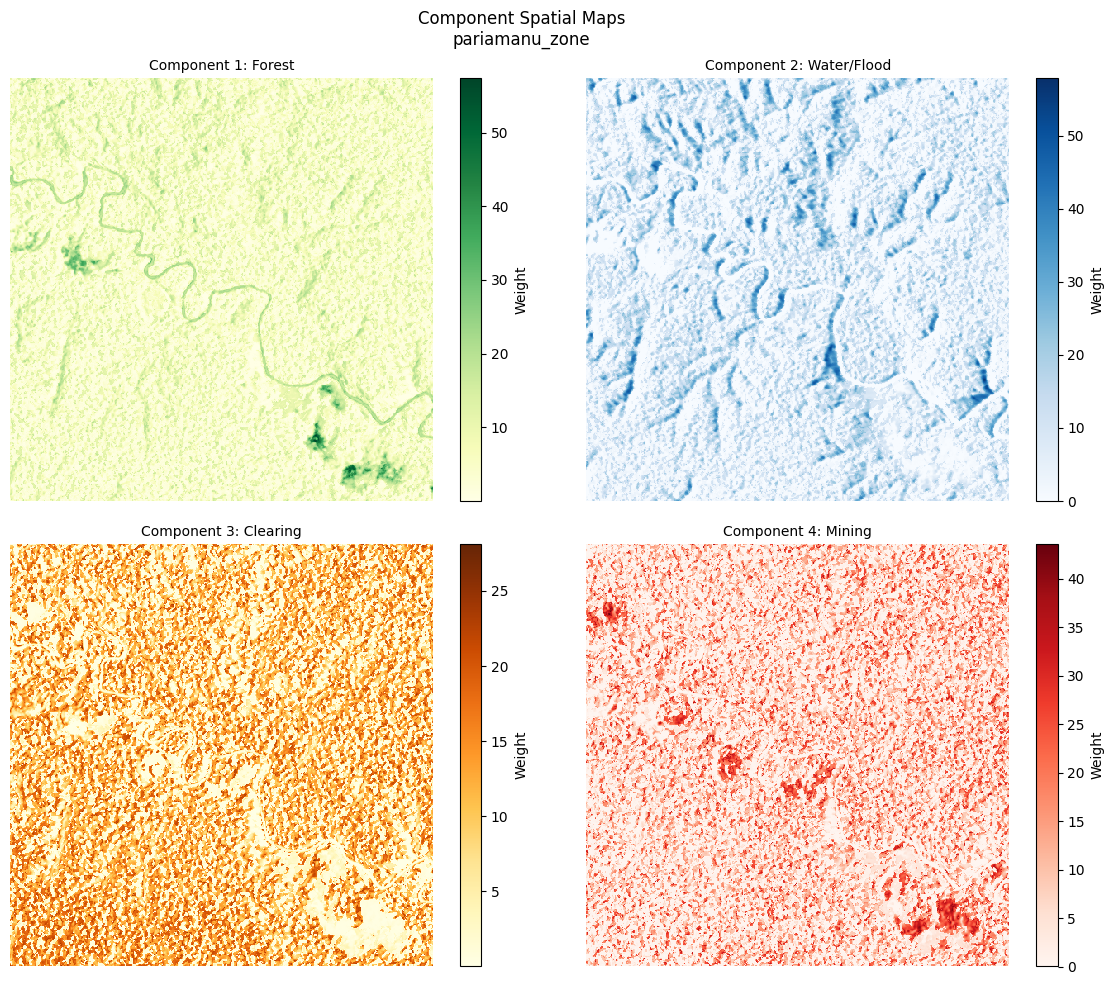

In [76]:
visualize_results(results)

Mining Component Emergence: Temporal-Spatial Analysis
This visualization demonstrates how NMF detects the emergence of mining activity over time by decomposing satellite radar data into interpretable components.
Method: NMF separates the time series into spatial patterns (H - where features occur) and temporal weights (W - when they're active). For the mining component, we compute weighted activation maps at each timestamp as: Activation(t) = W[t] × H, where W[t] is the component's temporal weight at time t.

Interpretation:
Top row (first period): Mining component shows minimal - the pattern is absent or below detection threshold, indicating no mining activity
Bottom row (last period): Same component now shows strong activation in specific areas - mining has emerged and intensified
Overlay images: Red highlights on SAR backscatter clearly delineate detected mining zones

The increasing temporal weight (W[0] → W[T]) captures mining expansion, while the fixed spatial pattern (H) identifies where this disturbance signature appears. Areas transitioning from black to red represent new mining development detected by the algorithm.

In [40]:
def visualize_component_appearance(results, stack_da, component_idx=2, threshold_percentile=50):
    """
    Show component going from absent to present by thresholding weak activations.
    """
    
    aoi_name = results["aoi_name"]
    W = results["W"]
    H = results["H"]
    valid_mask = results["valid_mask"]
    spatial_shape = results["band_info"]["spatial_shape"]
    H_full, W_full = spatial_shape
    dates = results["dates"]
    n_bands = results["band_info"]["n_bands"]
    n_timesteps = results["band_info"]["n_timesteps"]
    
    # Extract temporal activation
    temporal_activation, _ = extract_temporal_signatures(W, n_bands, n_timesteps)
    component_temporal = temporal_activation[:, component_idx]
    
    # Get spatial pattern
    component_spatial = H[component_idx, :]
    
    # Compute weighted spatial maps
    weight_first = component_temporal[0]
    weight_last = component_temporal[-1]
    
    weighted_spatial_first = weight_first * component_spatial
    weighted_spatial_last = weight_last * component_spatial
    
    # Reshape to spatial maps
    def to_spatial_map(values):
        map_flat = np.zeros(H_full * W_full)
        map_flat[valid_mask] = values
        return map_flat.reshape(H_full, W_full)
    
    map_first = to_spatial_map(weighted_spatial_first)
    map_last = to_spatial_map(weighted_spatial_last)
    
    # KEY CHANGE: Threshold to show only "real" activations
    # Compute threshold based on the LAST timestep (when mining is active)
    threshold = np.percentile(map_last[map_last > 0], threshold_percentile)
    
    # Mask weak activations to show "absent" vs "present"
    map_first_thresholded = np.where(map_first > threshold, map_first, 0)
    map_last_thresholded = np.where(map_last > threshold, map_last, 0)
    
    # Get VV backscatter
    vv_first = stack_da.sel(band="VV", time=dates[0]).values
    vv_last = stack_da.sel(band="VV", time=dates[-1]).values
    
    component_labels = ["Forest", "Water/Flood", "Clearing", "Mining"]
    
    # ══════════════════════════════════════════════════════
    # Figure: Absent → Present
    # ══════════════════════════════════════════════════════
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: First timestamp (ABSENT)
    ax = axes[0, 0]
    ax.imshow(vv_first, cmap='gray', vmin=0, vmax=0.5)
    ax.set_title(f"VV Backscatter\n{str(dates[0])[:10]}", fontsize=10)
    ax.axis('off')
    
    ax = axes[0, 1]
    im1 = ax.imshow(map_first_thresholded, cmap='hot', vmin=0, vmax=map_last.max())
    ax.set_title(f"Component {component_idx}: {component_labels[component_idx]}\n"
                 f"First period (weight={weight_first:.4f}) - ABSENT", 
                 fontsize=10, fontweight='bold', color='blue')
    ax.axis('off')
    plt.colorbar(im1, ax=ax, fraction=0.046, label='Activation')
    
    ax = axes[0, 2]
    ax.imshow(vv_first, cmap='gray', vmin=0, vmax=0.5)
    overlay_first = np.ma.masked_where(map_first_thresholded < 0.01, map_first_thresholded)
    ax.imshow(overlay_first, cmap='hot', alpha=0.7, vmin=0, vmax=map_last.max())
    ax.set_title(f"Overlay: Mining Component\n{str(dates[0])[:10]} - NOT DETECTED", 
                 fontsize=10, color='blue')
    ax.axis('off')
    
    # Row 2: Last timestamp (PRESENT)
    ax = axes[1, 0]
    ax.imshow(vv_last, cmap='gray', vmin=0, vmax=0.5)
    ax.set_title(f"VV Backscatter\n{str(dates[-1])[:10]}", fontsize=10)
    ax.axis('off')
    
    ax = axes[1, 1]
    im2 = ax.imshow(map_last_thresholded, cmap='hot', vmin=0, vmax=map_last.max())
    ax.set_title(f"Component {component_idx}: {component_labels[component_idx]}\n"
                 f"Last period (weight={weight_last:.4f}) - PRESENT", 
                 fontsize=10, fontweight='bold', color='red')
    ax.axis('off')
    plt.colorbar(im2, ax=ax, fraction=0.046, label='Activation')
    
    ax = axes[1, 2]
    ax.imshow(vv_last, cmap='gray', vmin=0, vmax=0.5)
    overlay_last = np.ma.masked_where(map_last_thresholded < 0.01, map_last_thresholded)
    ax.imshow(overlay_last, cmap='hot', alpha=0.7, vmin=0, vmax=map_last.max())
    ax.set_title(f"Overlay: Mining Component\n{str(dates[-1])[:10]} - DETECTED", 
                 fontsize=10, color='red')
    ax.axis('off')
    
    # Calculate detection statistics
    pixels_first = (map_first_thresholded > 0).sum()
    pixels_last = (map_last_thresholded > 0).sum()
    area_first = pixels_first * 30 * 30 / 1e6
    area_last = pixels_last * 30 * 30 / 1e6
    
    plt.suptitle(
        f"Mining Component Emergence: ABSENT → PRESENT — {aoi_name}\n"
        f"Detected area: {area_first:.2f} km² → {area_last:.2f} km² "
        f"({area_last - area_first:.2f} km² expansion)",
        fontsize=13, fontweight='bold'
    )
    plt.tight_layout()
    plt.savefig(BASE_DIR / f"{aoi_name}_component{component_idx}_absent_to_present.png", 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"Component {component_idx} Emergence — {aoi_name}")
    print(f"{'='*60}")
    print(f"Temporal weight change: {weight_first:.6f} → {weight_last:.6f} "
          f"({100*(weight_last-weight_first)/weight_first:.1f}% increase)")
    print(f"Detected pixels: {pixels_first:,} → {pixels_last:,}")
    print(f"Detected area: {area_first:.2f} km² → {area_last:.2f} km² (expansion: {area_last-area_first:.2f} km²)")


# Run it
for aoi_name, results in results.items():
    stack_da = STACKS[aoi_name]
    visualize_component_appearance(results, stack_da, component_idx=2, threshold_percentile=50)

KeyError: 'W_maps'